In [237]:
import orbit
from orbit.models import DLT
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components
from orbit.eda import eda_plot
from orbit.diagnostics.backtest import BackTester
from orbit.utils.params_tuning import grid_search_orbit

import pandas as pd
import pandahouse as ph
import numpy as np
import os

import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az

In [238]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
              'database':'simulator_20240120',
              'user':'student',
              'password':'dpo_python_2020'
             }

Данные возьму с 19 января, чтобы не брать в расчет данные от флешмоба, который не имел долгосрочный эффектов и чтобы не было выбросов

In [239]:
q = '''
SELECT 
    toDate(time) as day,
    uniqExact(user_id) as dau,
    count(action) as actions,
     sum(action = 'like') as likes,
    sum(action = 'view') as views,
    round(likes/views, 3) as ctr
FROM 
    {db}.feed_actions
WHERE toDate(time) between '2024-01-19' and '2024-02-09'
GROUP BY day
ORDER BY day
'''
df = ph.read_clickhouse(q, connection=connection)

In [240]:
print(df)

          day    dau  actions   likes    views    ctr
0  2024-01-19  16195  1334298  228125  1106173  0.206
1  2024-01-20  14073   559102   97982   461120  0.212
2  2024-01-21  17510   778839  133029   645810  0.206
3  2024-01-22  17703   737428  127420   610008  0.209
4  2024-01-23  18134   668421  115570   552851  0.209
5  2024-01-24  18651   704752  121752   583000  0.209
6  2024-01-25  18365   836150  149577   686573  0.218
7  2024-01-26  18038   796145  143119   653026  0.219
8  2024-01-27  18623   885750  154857   730893  0.212
9  2024-01-28  19376   746930  129397   617533  0.210
10 2024-01-29  19594   751535  129435   622100  0.208
11 2024-01-30  20061   791993  132894   659099  0.202
12 2024-01-31  20400   710641  120249   590392  0.204
13 2024-02-01  20198   800166  139146   661020  0.211
14 2024-02-02  19878   870974  151952   719022  0.211
15 2024-02-03  19554  1015944  182190   833754  0.219
16 2024-02-04  19572   909446  164565   744881  0.221
17 2024-02-05  19768   86483

In [241]:
df.corr()

,day,dau,actions,likes,views,ctr
day,1.000000,0.680191,0.115453,0.138486,0.110339,0.158116
dau,0.680191,1.000000,0.043030,0.048684,0.041747,-0.004124
actions,0.115453,0.043030,1.000000,0.992716,0.999672,0.077446
likes,0.138486,0.048684,0.992716,1.000000,0.989304,0.196353
views,0.110339,0.041747,0.999672,0.989304,1.000000,0.052017
ctr,0.158116,-0.004124,0.077446,0.196353,0.052017,1.000000


In [242]:
print(df.dtypes)

day        datetime64[ns]
dau                uint64
actions            uint64
likes              uint64
views              uint64
ctr               float64
dtype: object


Основную метрику возьму "количество действий", так как она хорошо отражает активность пользователей в приложении, а регрессором будет DAU, так как от количества уникальных пользователей зависит и активность в приложении (прямая корреляция, пусть и слабая, но между ними присутствует).

## Предварительный просмотр данных

Text(0, 0.5, 'Пользователи')

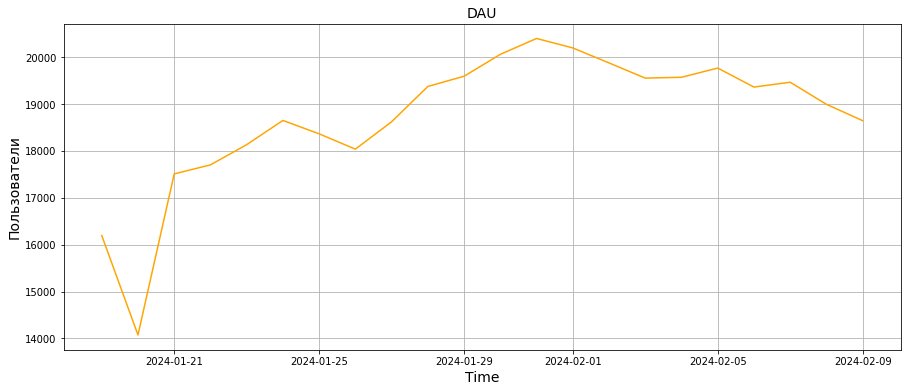

In [243]:
plt.figure(figsize=(15, 6))
ax = sns.lineplot(x="day", y="dau", data=df, color = 'orange')
ax.set_title('DAU', fontsize = 14)
plt.grid()
plt.xlabel('Time', fontsize = 14)
plt.ylabel('Пользователи', fontsize = 14)

Text(0, 0.5, 'Пользователи')

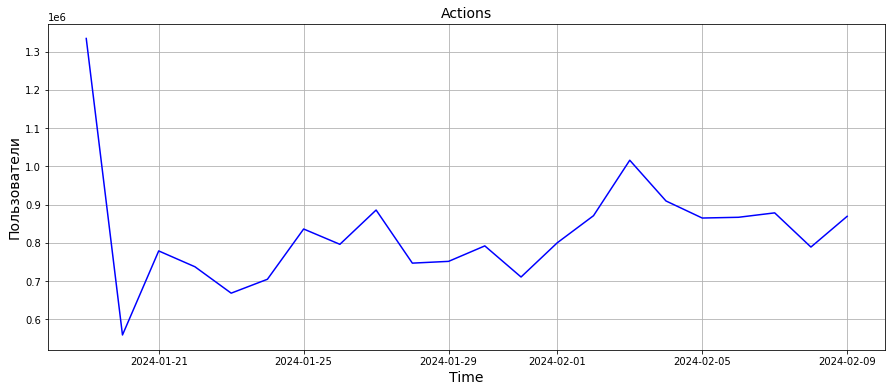

In [244]:
plt.figure(figsize=(15, 6))
ax = sns.lineplot(x="day", y="actions", data=df, color = 'blue')
ax.set_title('Actions', fontsize = 14)
plt.grid()
plt.xlabel('Time', fontsize = 14)
plt.ylabel('Пользователи', fontsize = 14)

Как видно по графикам, DAU снижается с 1 февраля, а actions - с 2 февраля

## Построю тепловые карты

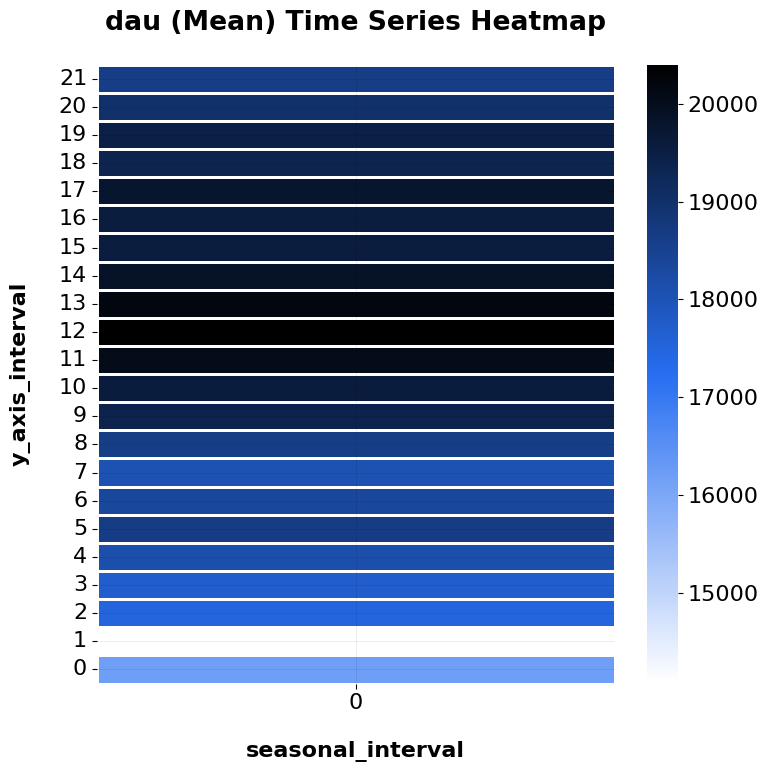

In [245]:
#dau
d = eda_plot.ts_heatmap(df=df, date_col="day", value_col='dau', seasonal_interval=24, normalization=False)

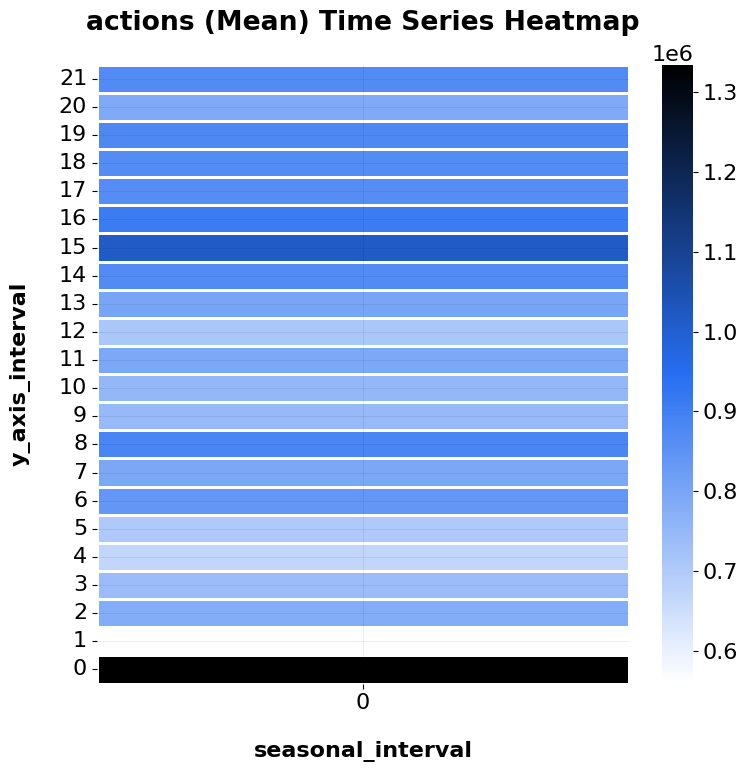

In [246]:
#actions
d = eda_plot.ts_heatmap(df=df, date_col="day", value_col='actions', seasonal_interval=24, normalization=False)

## Модель прогноза

По заданию нужно сделать прогноз на месяц, но падение показателей началось только с 1ого февраля, а для успешного обучения и бэктестинга модели временный диапазон данных должен как минимум совпадать с периодом прогноза,а то и быть больше. Поэтому в данном случае хватает данных для прогноза только на 9 дней вперед (на 09.02.24). Построю две модели с разными estimator: 'stan-map' и 'stan-mcmc'.

## Estimator - 'stan-map'

In [247]:
dlt_map = DLT(response_col="actions", 
          date_col="day", 
          seasonality=7,
          estimator='stan-map',
          global_trend_option = 'linear',
          regressor_col = ['dau'],
          regression_penalty ='auto_ridge',
          n_bootstrap_draws=1000)

2024-02-10 12:24:24 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.


In [248]:
dlt_map.fit(df)

In [249]:
future_df_map = dlt_map.make_future_df(periods = 9)

print(future_df_map)

         day
0 2024-02-10
1 2024-02-11
2 2024-02-12
3 2024-02-13
4 2024-02-14
5 2024-02-15
6 2024-02-16
7 2024-02-17
8 2024-02-18


Предскажу значения DAU

In [250]:
dlt_reg_dau = DLT(response_col="dau", 
          date_col="day", 
          seasonality=7,
          estimator='stan-map',
          global_trend_option = 'linear',
          regression_penalty ='auto_ridge',
          n_bootstrap_draws=1000)

2024-02-10 12:24:35 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.


In [251]:
dlt_reg_dau.fit(df)

In [252]:
future_reg_dau = dlt_reg_dau.predict(future_df_map)

print(future_reg_dau)

         day  prediction_5    prediction  prediction_95
0 2024-02-10  17544.544488  18532.420603   19466.549243
1 2024-02-11  17020.036850  18436.175611   19913.300741
2 2024-02-12  16207.903256  18350.194017   20282.104664
3 2024-02-13  15762.055417  18272.023142   20548.460013
4 2024-02-14  15357.280969  18205.700842   20799.960742
5 2024-02-15  14735.887942  18142.657402   21074.482173
6 2024-02-16  14535.653302  18084.637050   21514.773670
7 2024-02-17  14369.927584  18031.635169   21740.015632
8 2024-02-18  13938.231715  17983.848064   21939.676524


In [253]:
future_df_map['dau'] = future_reg_dau.prediction
future_df_map.head(10)

,day,dau
0,2024-02-10,18532.420603
1,2024-02-11,18436.175611
2,2024-02-12,18350.194017
3,2024-02-13,18272.023142
4,2024-02-14,18205.700842
5,2024-02-15,18142.657402
6,2024-02-16,18084.637050
7,2024-02-17,18031.635169
8,2024-02-18,17983.848064


In [254]:
predicted_df_map = dlt_map.predict(df = future_df_map, decompose = True)
predicted_df_map.head()

,day,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_5,seasonality,seasonality_95,regression_5,regression,regression_95
0,2024-02-10,796088.489406,869321.518477,9.393988e+05,796088.491636,869321.520706,9.393988e+05,-0.002229,-0.002229,-0.002229,0.0,0.0,0.0
1,2024-02-11,767423.004255,869321.445113,9.735949e+05,767422.995158,869321.436017,9.735949e+05,0.009097,0.009097,0.009097,0.0,0.0,0.0
2,2024-02-12,745156.778393,869321.475656,9.960867e+05,745156.654064,869321.351327,9.960865e+05,0.124329,0.124329,0.124329,0.0,0.0,0.0
3,2024-02-13,718708.200212,869321.275286,1.019554e+06,718708.191563,869321.266637,1.019554e+06,0.008649,0.008649,0.008649,0.0,0.0,0.0
4,2024-02-14,704111.890148,869321.126542,1.035044e+06,704111.945554,869321.181947,1.035044e+06,-0.055406,-0.055406,-0.055406,0.0,0.0,0.0


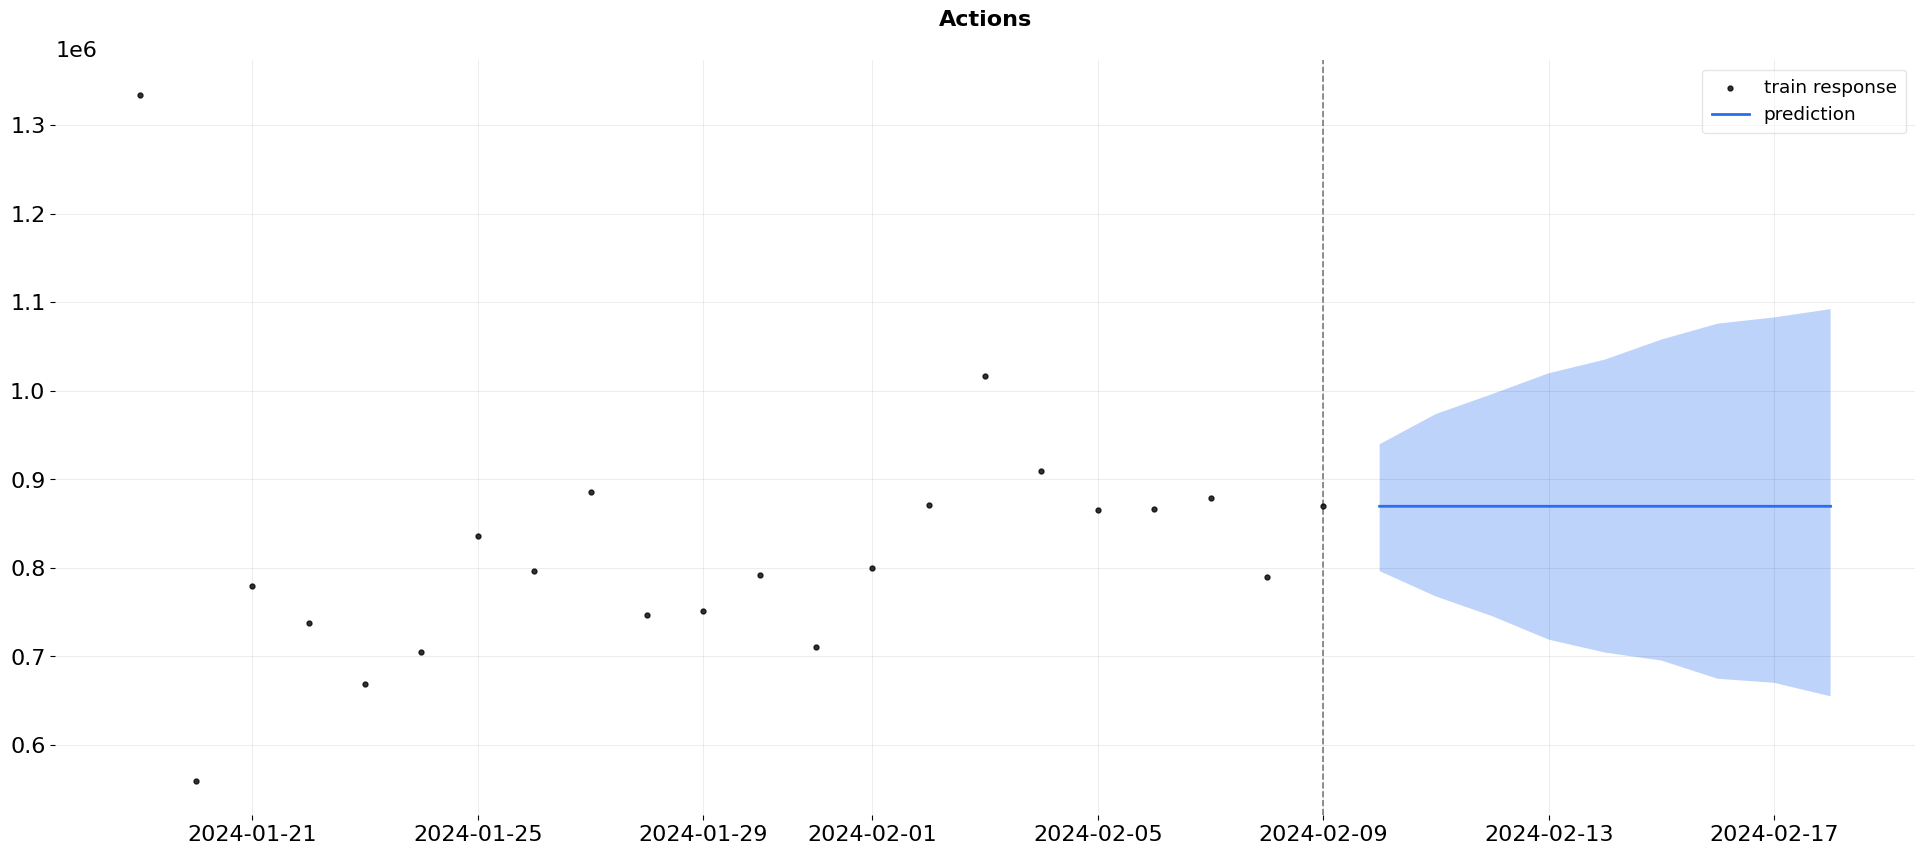

In [255]:
_ = plot_predicted_data(df, predicted_df_map, "day", 'actions', 
                        title='Actions', figsize=(24, 10))

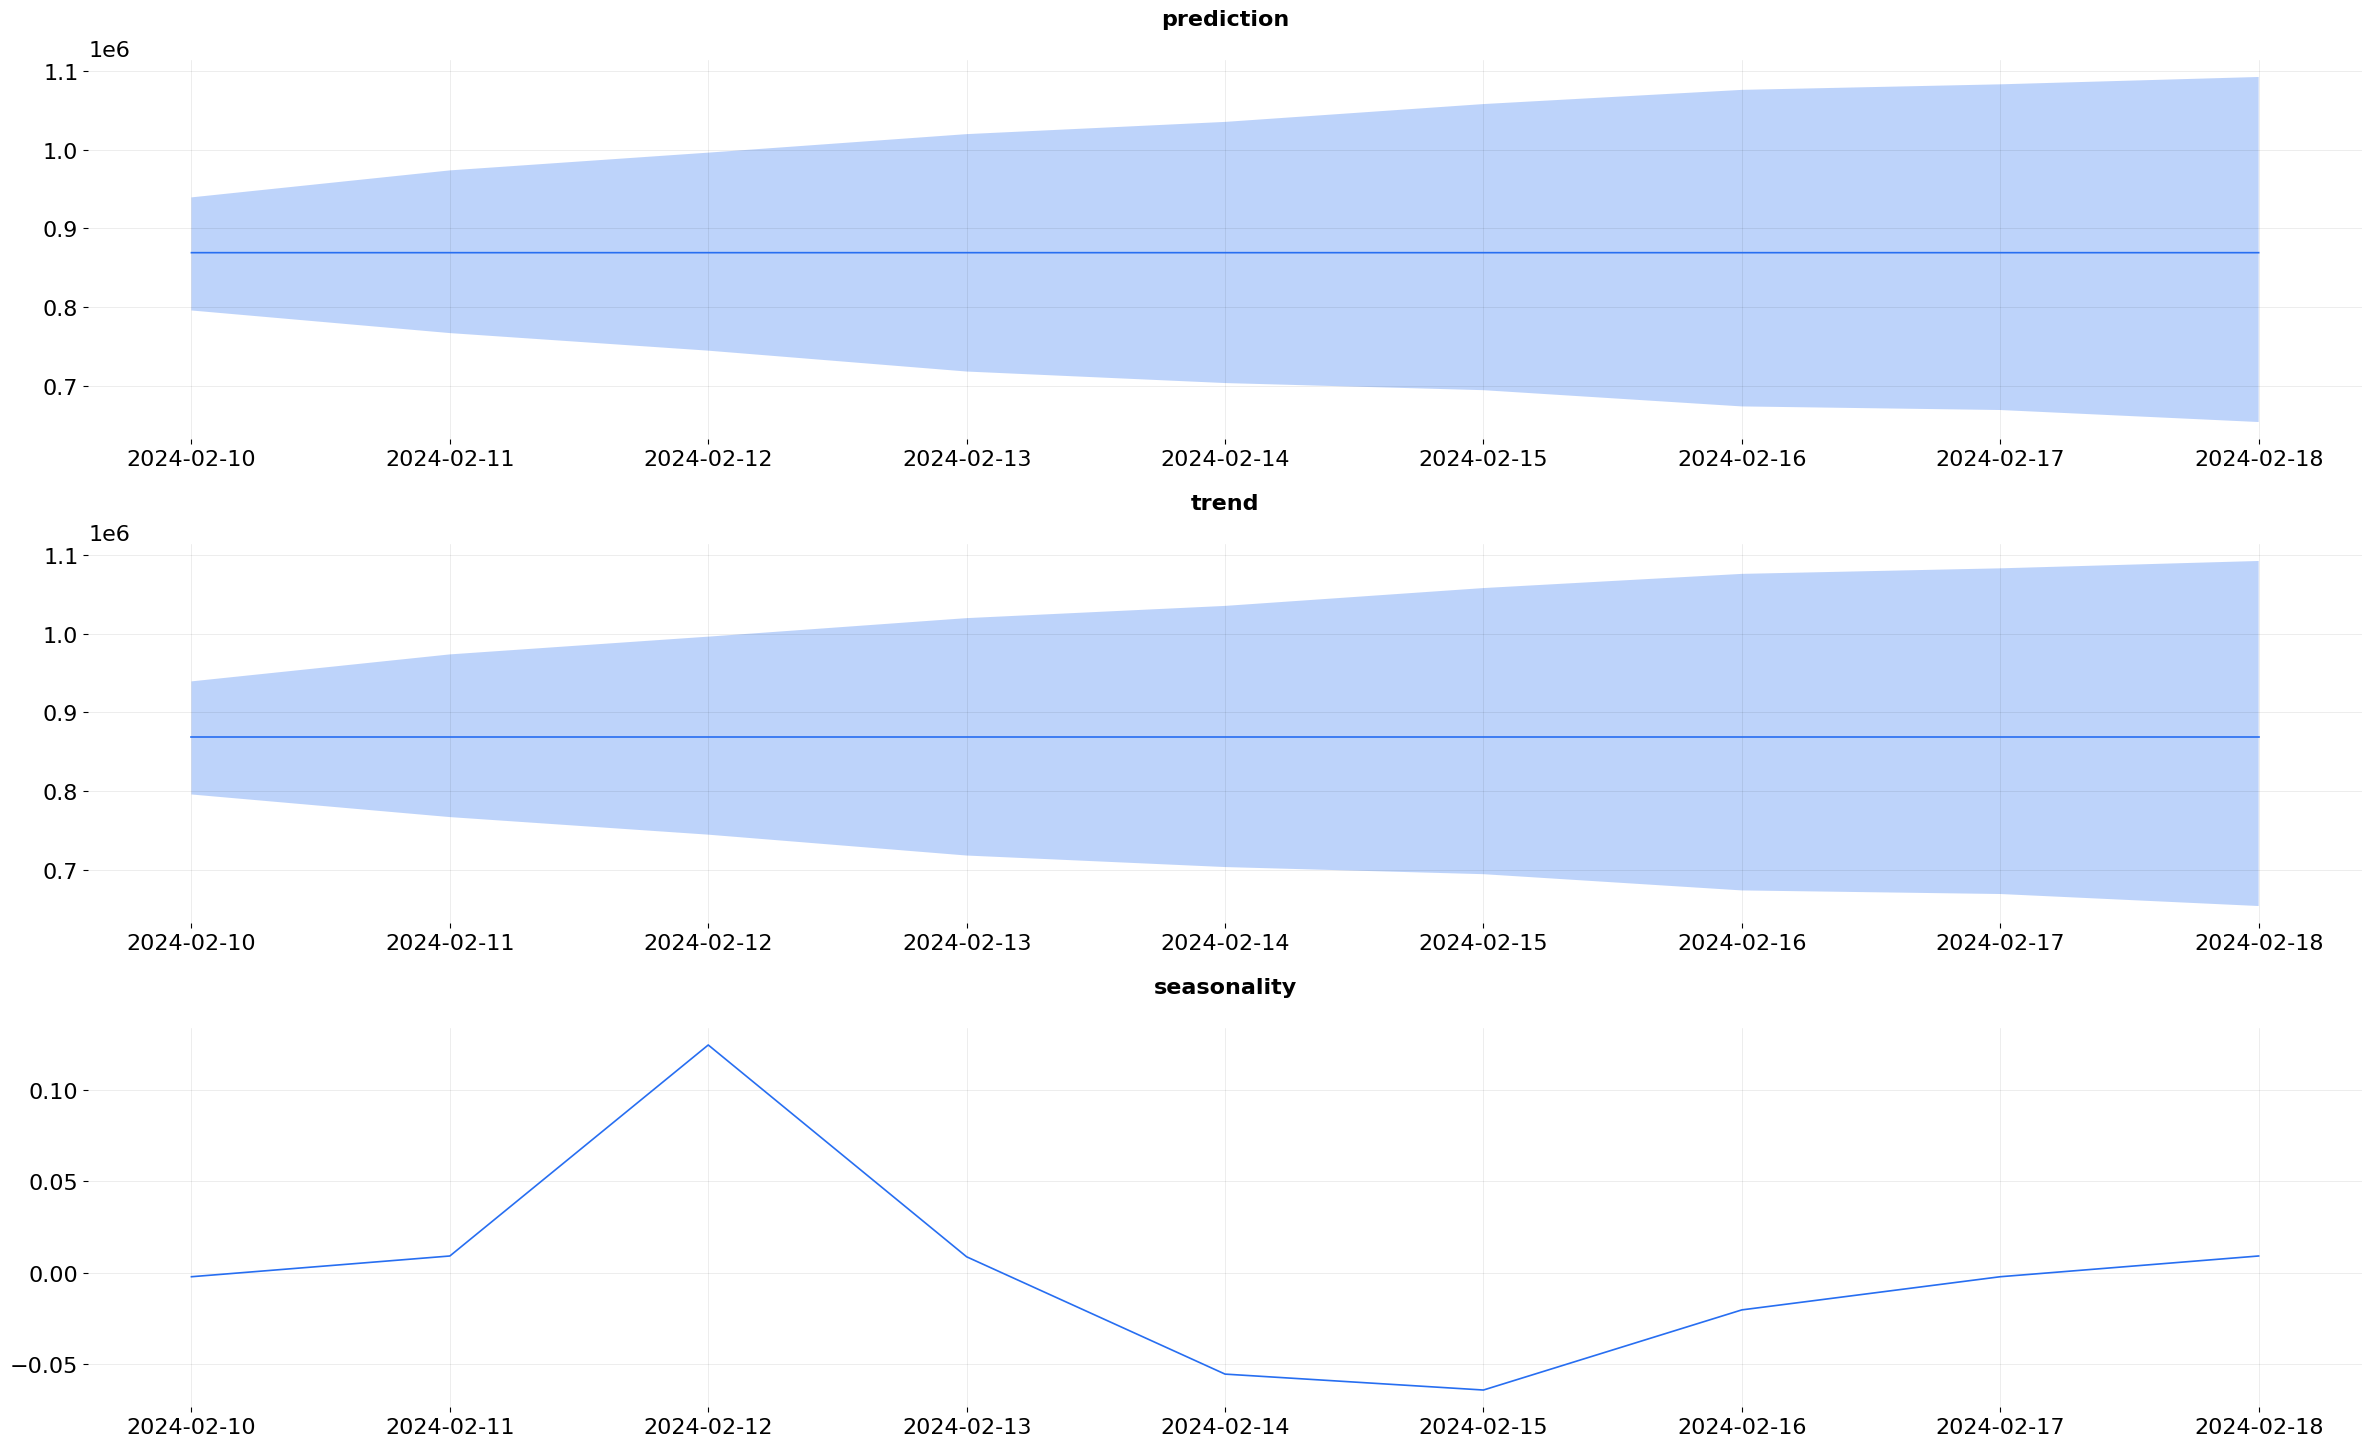

In [256]:
 l = plot_predicted_components(predicted_df_map, "day", 
                              plot_components=['prediction', 'trend', 'seasonality'], figsize=(24, 15))

In [257]:
df['dau'] = df['dau'].astype(float)
df['actions'] = df['dau'].astype(float)

In [258]:
map_actions = BackTester(
    model=dlt_map, #наша моделька
    df=df, #датафрейм для обучения
    min_train_len=7, #самый маленький кусочек данных, с которого начинается обучение
    incremental_len=1, #на сколько происходит прирост тренировочных данных
    forecast_len=1, #горизонт пронозирования
    window_type="rolling" #тип окошка
)

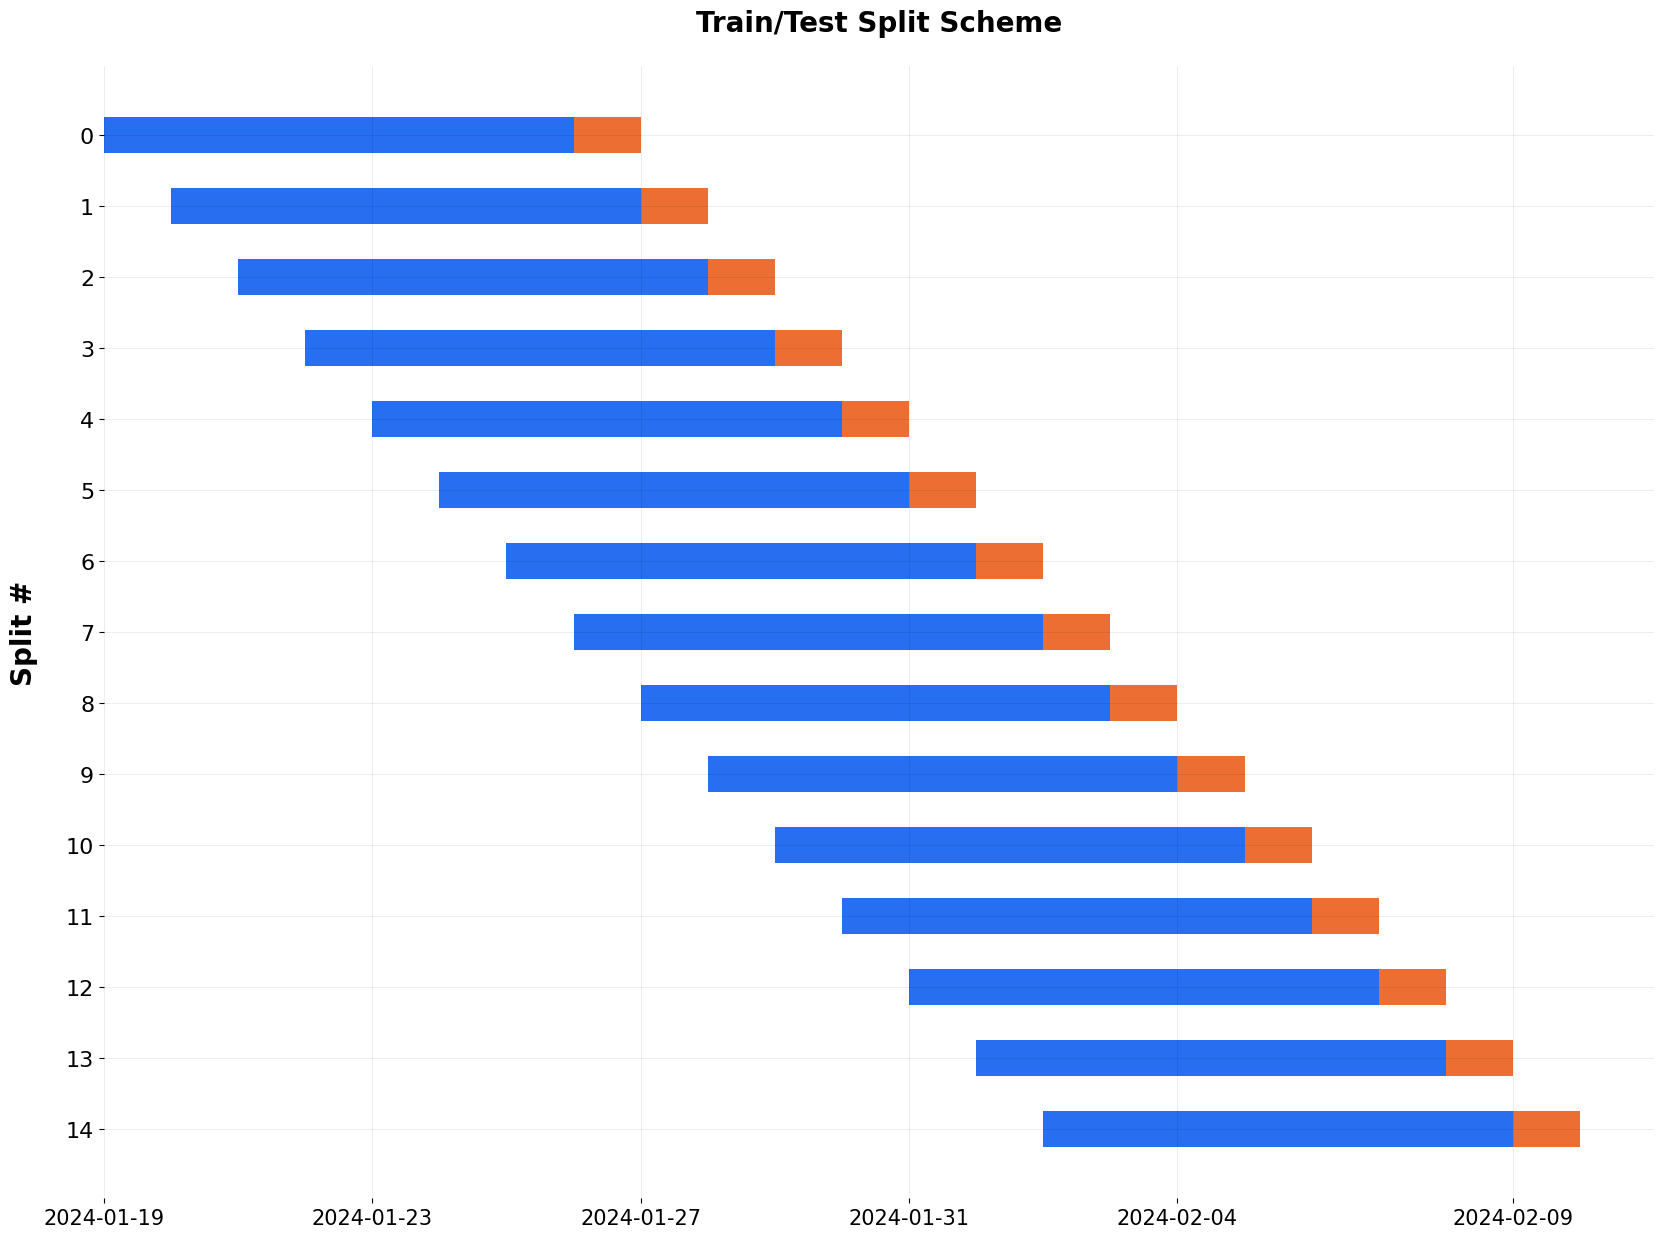

In [259]:
map_actions.plot_scheme()

In [260]:
map_actions.fit_predict()
map_actions.score()

,metric_name,metric_values,is_training_metric
0,smape,0.004808,False
1,wmape,0.004932,False
2,mape,0.004829,False
3,mse,33183.870592,False
4,mae,95.849285,False
5,rmsse,0.470911,False


In [261]:
map_actions_1 = BackTester(
    model=dlt_map, #наша моделька
    df=df, #датафрейм для обучения
    min_train_len=7, #самый маленький кусочек данных, с которого начинается обучение
    incremental_len=1, #на сколько происходит прирост тренировочных данных
    forecast_len=1, #горизонт пронозирования
    window_type="expanding" #тип окошка
)

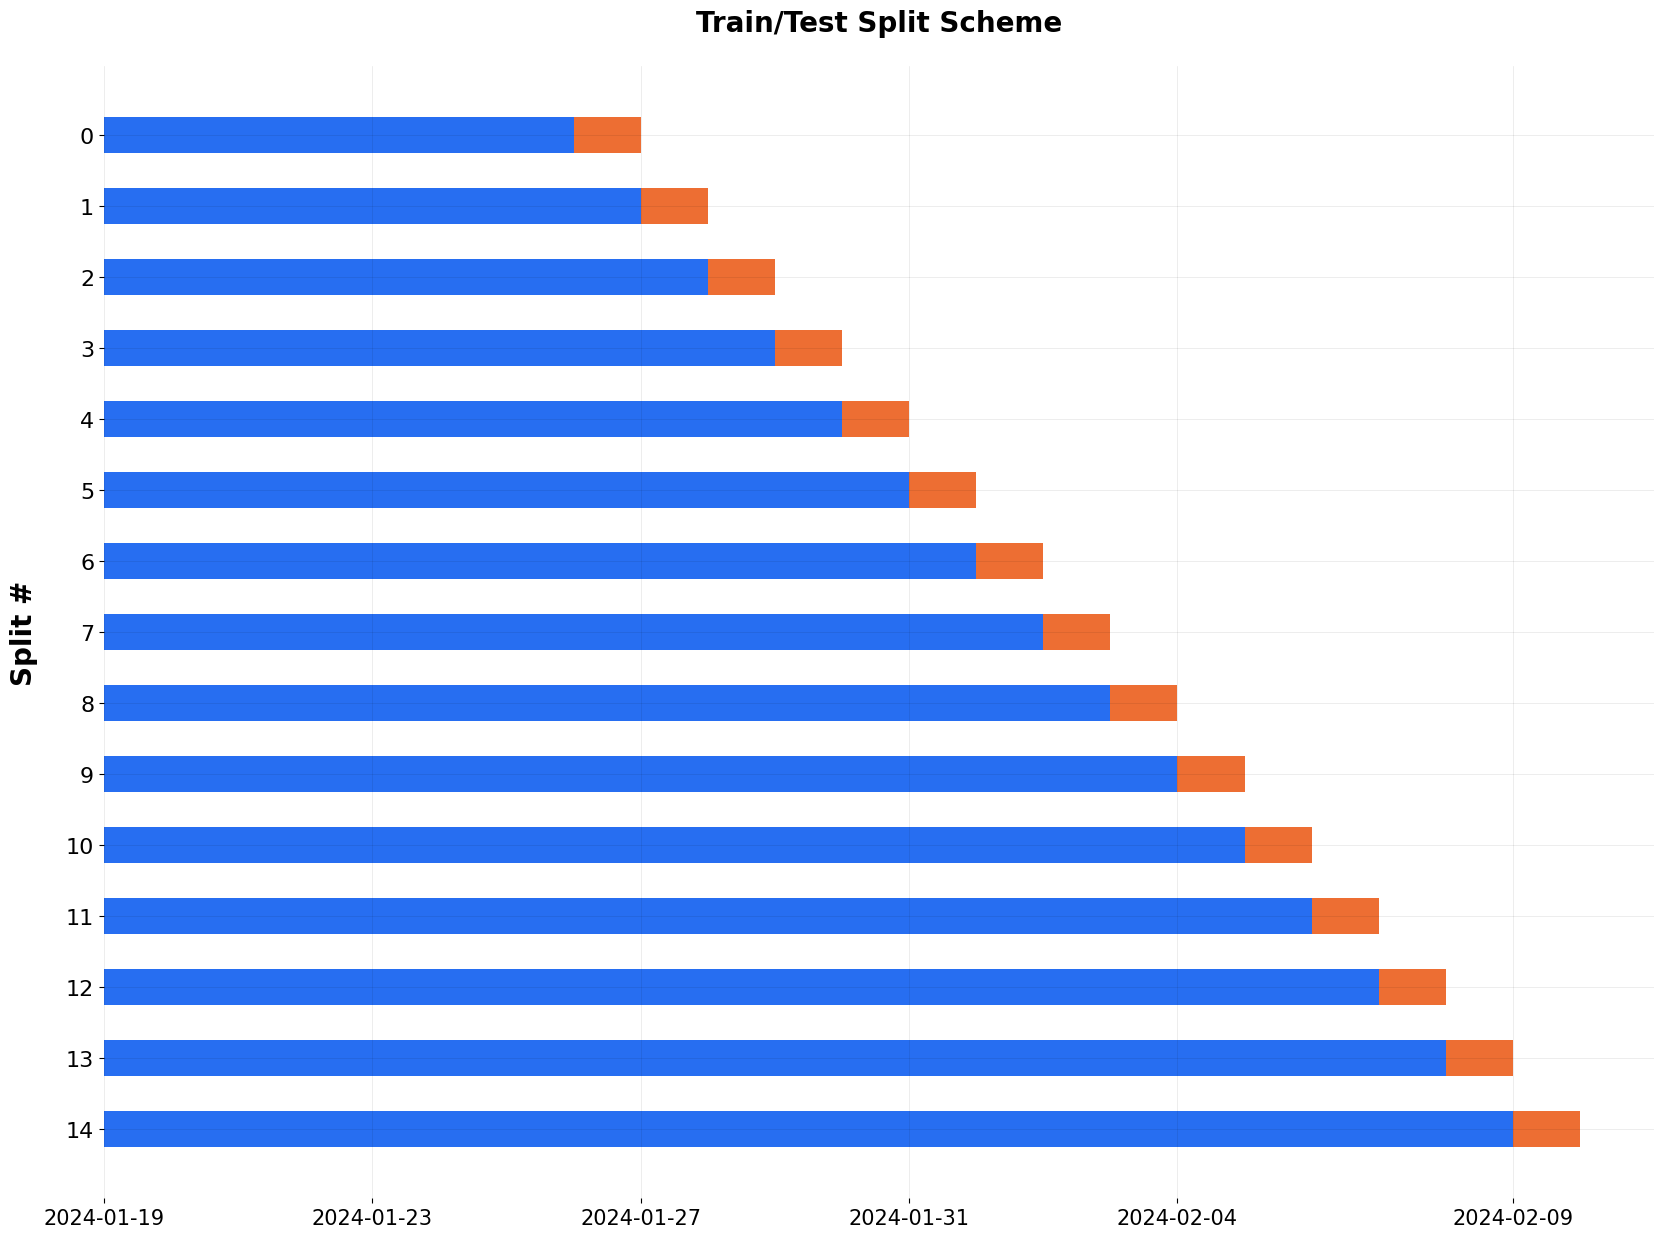

In [262]:
map_actions_1.plot_scheme()

In [263]:
map_actions_1.fit_predict()
map_actions_1.score()

,metric_name,metric_values,is_training_metric
0,smape,0.000002,False
1,wmape,0.000002,False
2,mape,0.000002,False
3,mse,0.007446,False
4,mae,0.030192,False
5,rmsse,0.000223,False


В алгоритме estimator = 'stan-map' лучшие показатели продемонстрировала модель с global_trend_option = 'linear', backtesting = 'expanding'

(Оставил только лучшую модель)

## Estimator - 'stan-mcmc'

Данные возьму с периодои в час для лучшего обучения модели

In [350]:
query = '''
SELECT 
    toStartOfHour(time) as hour_time,
    uniqExact(user_id) as dau,
    count(action) as actions,
     sum(action = 'like') as likes,
    sum(action = 'view') as views,
    round(likes/views, 3) as ctr
FROM 
    {db}.feed_actions
WHERE toDate(time) between '2024-01-19' and '2024-02-09'
GROUP BY hour_time
ORDER BY hour_time
'''
df_1 = ph.read_clickhouse(query, connection=connection)

In [351]:
dlt_mcmc = DLT(response_col="actions", 
          date_col="hour_time", 
          seasonality=7,
          estimator='stan-mcmc',
          global_trend_option = 'loglinear',
          regressor_col = ['dau'],
          regression_penalty ='auto_ridge',
          n_bootstrap_draws=1000)

In [352]:
dlt_mcmc.fit(df_1)

2024-02-10 15:04:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [353]:
future_df_mcmc = dlt_mcmc.make_future_df(periods = 24 * 9)

print(future_df_mcmc)

              hour_time
0   2024-02-10 00:00:00
1   2024-02-10 01:00:00
2   2024-02-10 02:00:00
3   2024-02-10 03:00:00
4   2024-02-10 04:00:00
..                  ...
211 2024-02-18 19:00:00
212 2024-02-18 20:00:00
213 2024-02-18 21:00:00
214 2024-02-18 22:00:00
215 2024-02-18 23:00:00

[216 rows x 1 columns]


In [354]:
dlt_reg_dau_mcmc = DLT(response_col="dau", 
          date_col="hour_time", 
          seasonality=7,
          estimator='stan-mcmc',
          global_trend_option = 'loglinear',
          regression_penalty ='auto_ridge',
          n_bootstrap_draws=1000)

In [355]:
dlt_reg_dau_mcmc.fit(df_1)

2024-02-10 15:05:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [356]:
future_reg_dau_mcmc = dlt_reg_dau_mcmc.predict(future_df_mcmc)

print(future_reg_dau_mcmc)

              hour_time  prediction_5   prediction  prediction_95
0   2024-02-10 00:00:00   1169.468746  1402.010109    1624.090604
1   2024-02-10 01:00:00    802.319937  1234.833518    1732.670182
2   2024-02-10 02:00:00    414.440384  1114.276414    1869.496479
3   2024-02-10 03:00:00     61.911048   998.102651    2001.199335
4   2024-02-10 04:00:00   -264.309081   904.115303    2180.600996
..                  ...           ...          ...            ...
211 2024-02-18 19:00:00 -15958.714998   375.272324   16080.119474
212 2024-02-18 20:00:00 -16031.420851   436.424993   16229.601200
213 2024-02-18 21:00:00 -15925.661436   347.731662   16356.204556
214 2024-02-18 22:00:00 -16208.919828   352.327503   16302.785649
215 2024-02-18 23:00:00 -16090.926288   180.109265   16337.593728

[216 rows x 4 columns]


In [357]:
future_df_mcmc['dau'] = future_reg_dau_mcmc.prediction
future_df_mcmc.head(10)

,hour_time,dau
0,2024-02-10 00:00:00,1402.010109
1,2024-02-10 01:00:00,1234.833518
2,2024-02-10 02:00:00,1114.276414
3,2024-02-10 03:00:00,998.102651
4,2024-02-10 04:00:00,904.115303
5,2024-02-10 05:00:00,800.357553
6,2024-02-10 06:00:00,748.965774
7,2024-02-10 07:00:00,695.280334
8,2024-02-10 08:00:00,655.488377
9,2024-02-10 09:00:00,616.071303


In [358]:
predicted_df_mcmc = dlt_mcmc.predict(df = future_df_mcmc, decompose = True)
predicted_df_mcmc.head()

,hour_time,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_5,seasonality,seasonality_95,regression_5,regression,regression_95
0,2024-02-10 00:00:00,31153.633585,34338.340686,37389.279094,2080.506860,5373.036062,8641.934022,-157.073000,-79.52425,-8.523980,28066.700179,29109.935901,29913.848498
1,2024-02-10 01:00:00,26926.906454,31827.467043,36613.983419,1310.409502,6239.546878,11084.814543,1.687080,20.81440,40.017535,24720.008709,25638.848330,26346.901869
2,2024-02-10 02:00:00,23439.809339,30096.741277,36946.751714,308.708296,7061.432155,13677.155266,0.796341,14.92410,36.323200,22306.588105,23135.721185,23774.647281
3,2024-02-10 03:00:00,19064.859932,28549.008396,37321.810221,-1753.748431,7732.956456,16575.752321,8.362730,119.36900,282.674000,19980.917157,20723.605339,21295.917399
4,2024-02-10 04:00:00,15370.179014,26956.930823,37708.100954,-3549.816873,8189.913361,18919.524240,-1.190710,24.49320,177.188000,18099.393830,18772.146027,19290.565741


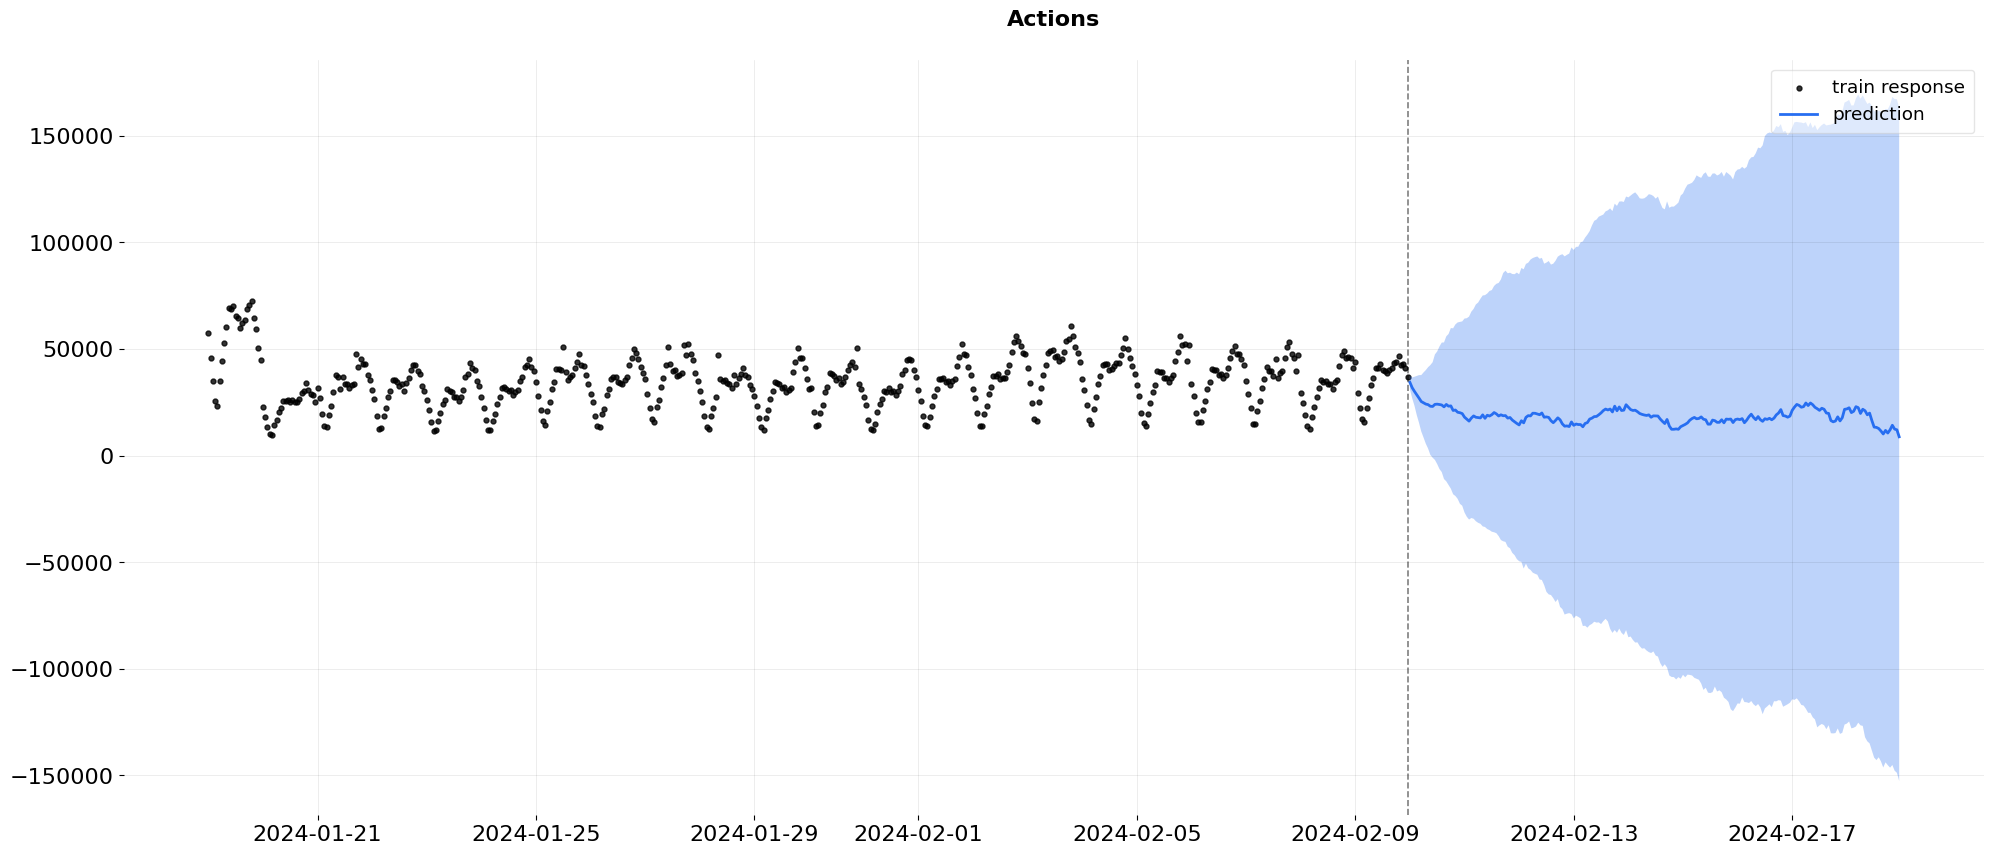

In [359]:
_ = plot_predicted_data(df_1, predicted_df_mcmc, "hour_time", 'actions', 
                        title='Actions', figsize=(24, 10))

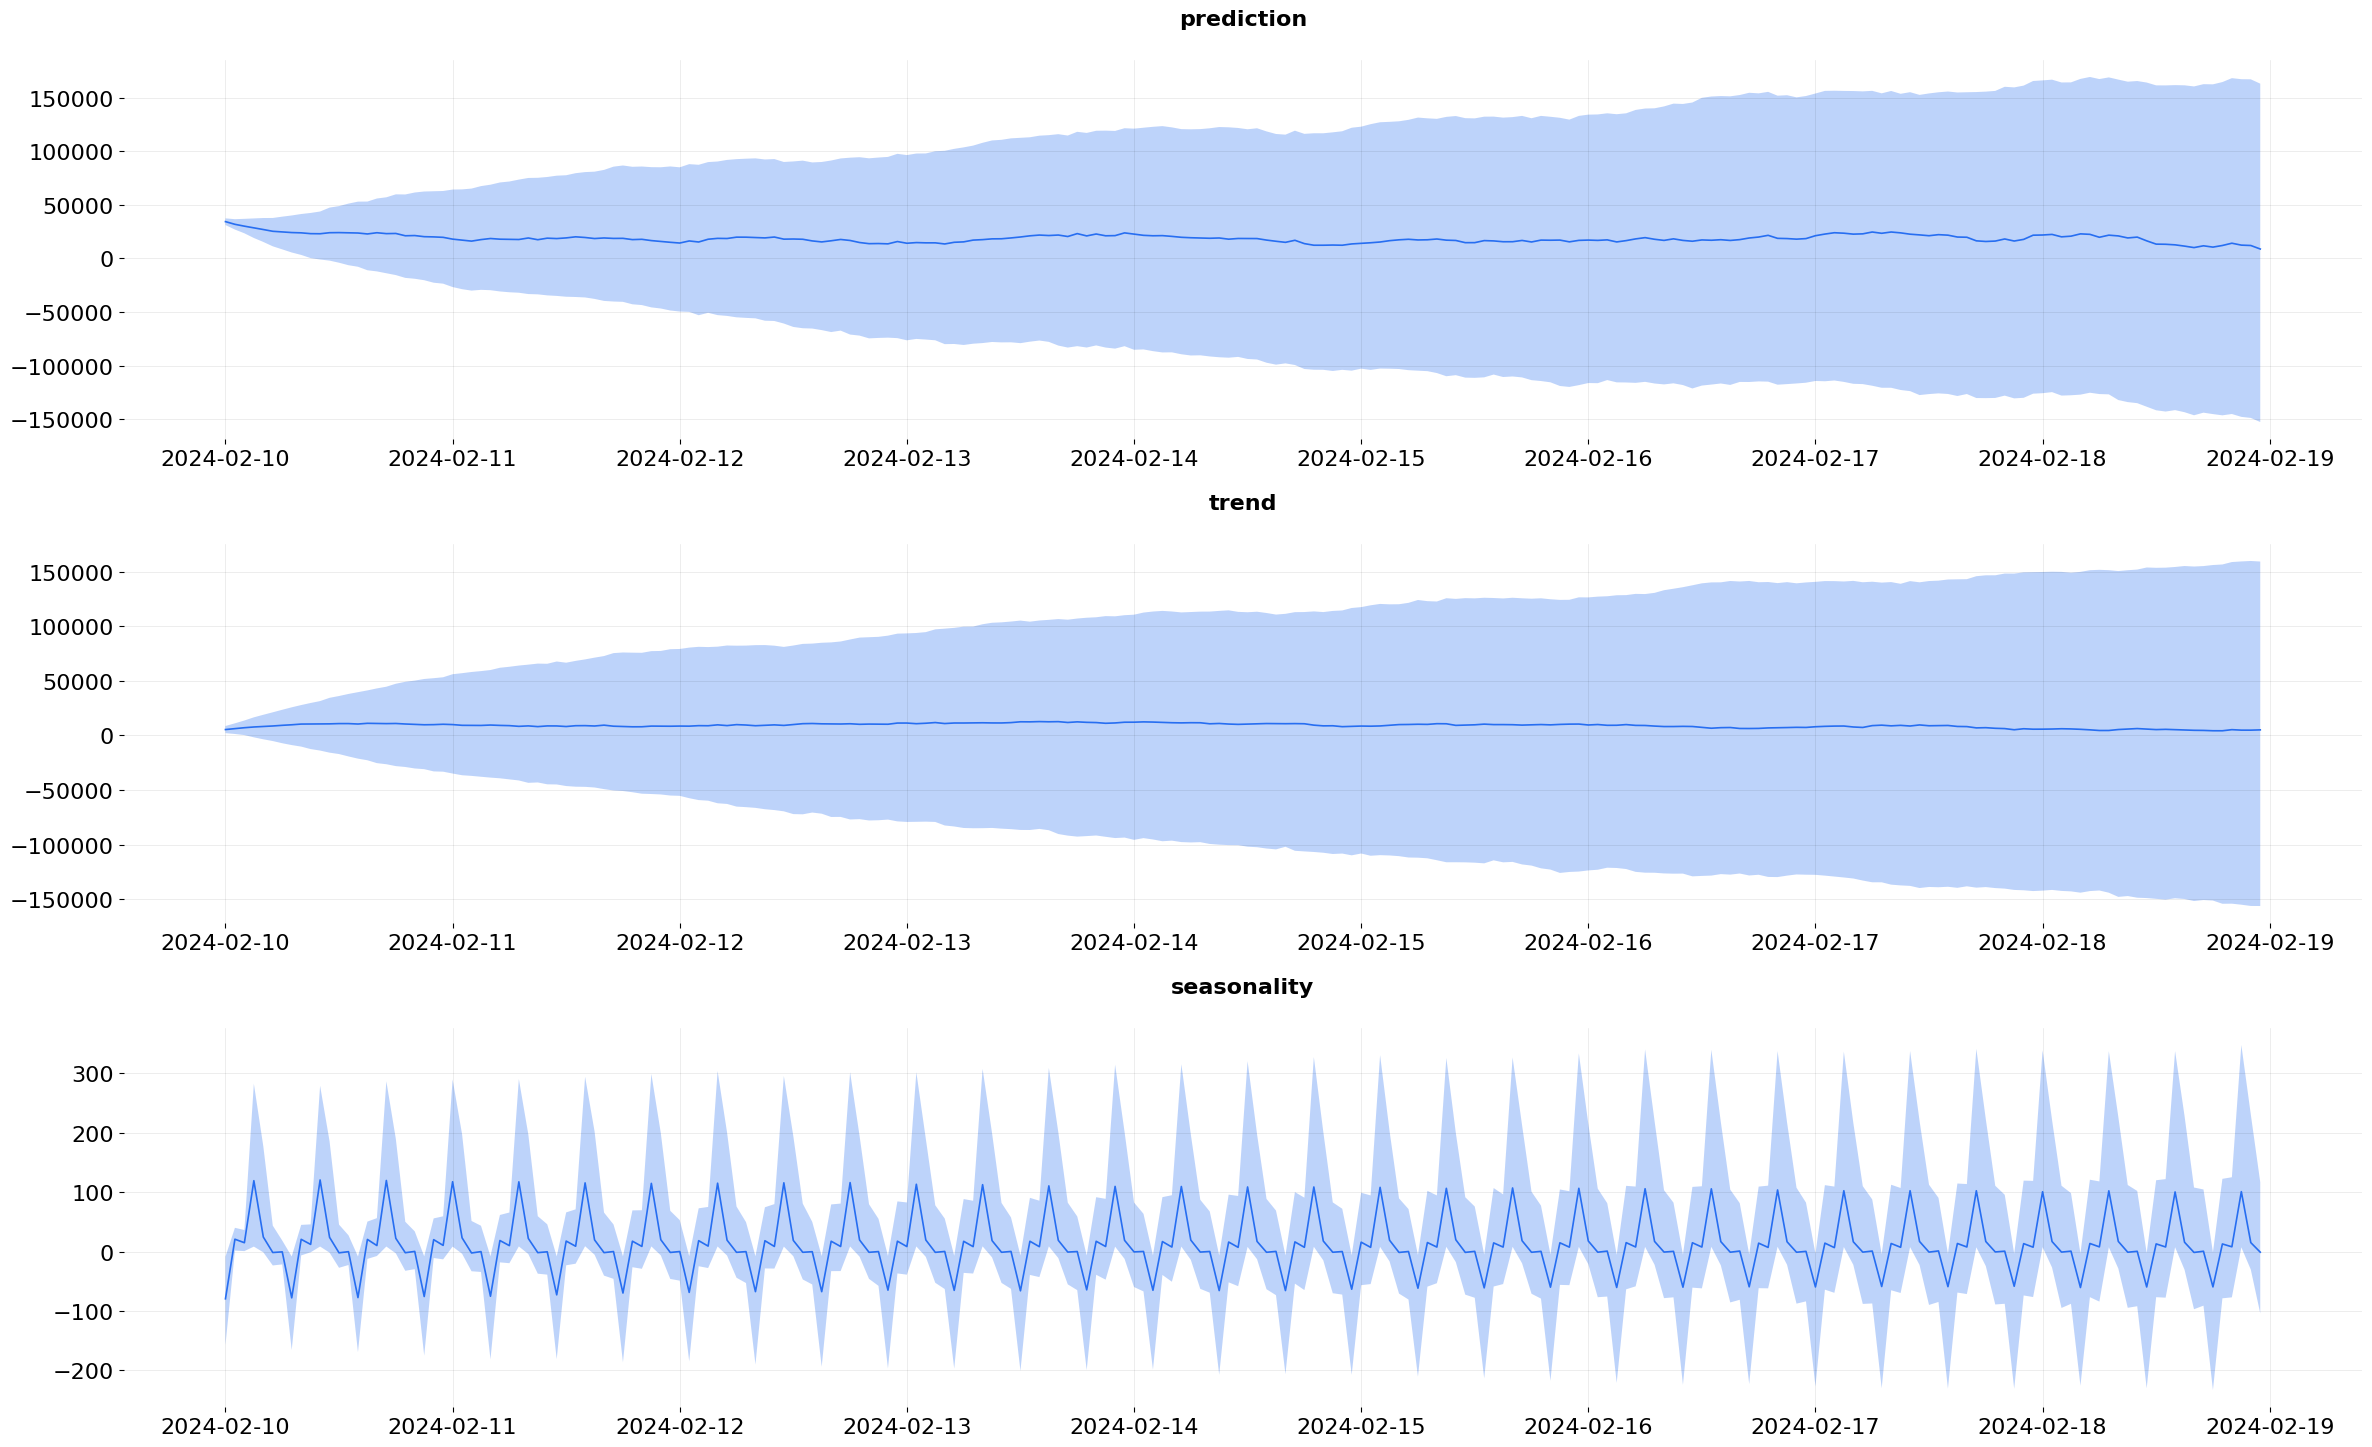

In [360]:
 l = plot_predicted_components(predicted_df_mcmc, "hour_time", 
                              plot_components=['prediction', 'trend', 'seasonality'], figsize=(24, 15))

In [361]:
df_1['dau'] = df_1['dau'].astype(float)
df_1['actions'] = df_1['dau'].astype(float)

In [362]:
mcmc_actions = BackTester(
    model=dlt_mcmc, #наша моделька
    df=df_1, #датафрейм для обучения
    min_train_len=24, #самый маленький кусочек данных, с которого начинается обучение
    incremental_len=24, #на сколько происходит прирост тренировочных данных
    forecast_len=24, #горизонт пронозирования
    window_type="rolling" #тип окошка
)

In [363]:
mcmc_actions.fit_predict()
mcmc_actions.score()

2024-02-10 15:06:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2024-02-10 15:06:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2024-02-10 15:06:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2024-02-10 15:06:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2024-02-10 15:06:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2024-02-10 15:07:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2024-02-10 15:07:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2024-02-10 15:07:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2024-02-10 15:07:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2024-02-10 15:07:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2024-02-10 15:07:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2024-02-10 15:07:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2024-02-10 15:07:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2024-02-10 15:08:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2024-02-10 15:08:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2024-02-10 15:08:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2024-02-10 15:08:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2024-02-10 15:08:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2024-02-10 15:08:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2024-02-10 15:08:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2024-02-10 15:08:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

,metric_name,metric_values,is_training_metric
0,smape,3.754292e-07,False
1,wmape,3.751873e-07,False
2,mape,3.754291e-07,False
3,mse,5.951779e-07,False
4,mae,6.624237e-04,False
5,rmsse,3.554597e-06,False


In [364]:
mcmc_actions_1 = BackTester(
    model=dlt_mcmc, #наша моделька
    df=df_1, #датафрейм для обучения
    min_train_len=24, #самый маленький кусочек данных, с которого начинается обучение
    incremental_len=24, #на сколько происходит прирост тренировочных данных
    forecast_len=24, #горизонт пронозирования
    window_type="expanding" #тип окошка
)

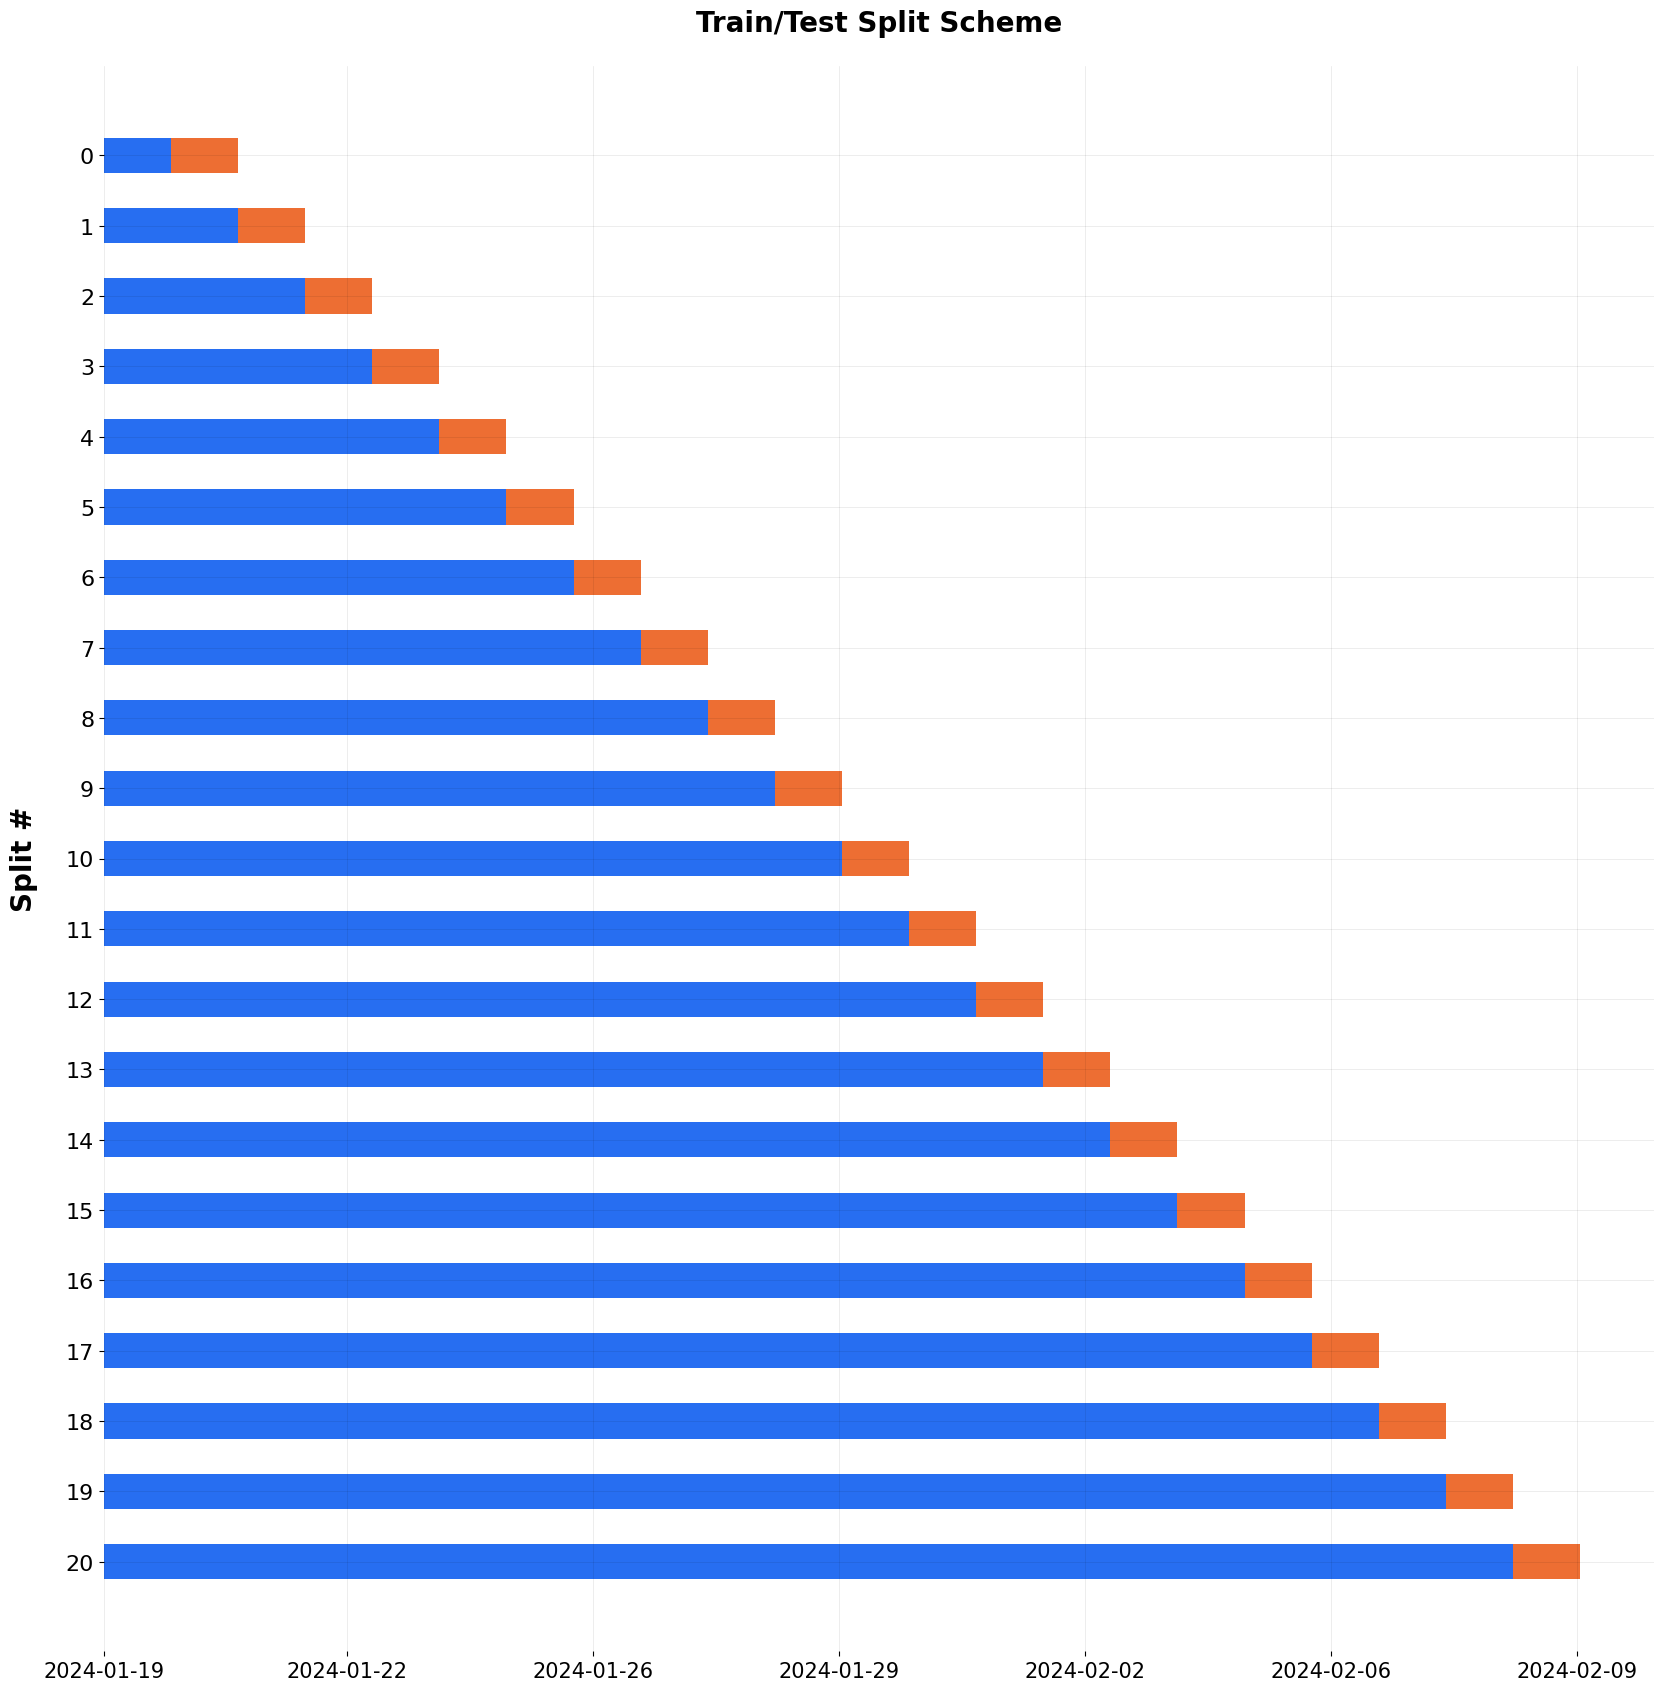

In [365]:
mcmc_actions_1.plot_scheme()

In [366]:
mcmc_actions_1.fit_predict()
mcmc_actions_1.score()

2024-02-10 15:09:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2024-02-10 15:09:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2024-02-10 15:10:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2024-02-10 15:10:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2024-02-10 15:10:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2024-02-10 15:11:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2024-02-10 15:11:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2024-02-10 15:12:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2024-02-10 15:13:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2024-02-10 15:14:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2024-02-10 15:14:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2024-02-10 15:15:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2024-02-10 15:17:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2024-02-10 15:18:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2024-02-10 15:19:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2024-02-10 15:20:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2024-02-10 15:22:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2024-02-10 15:23:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2024-02-10 15:25:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2024-02-10 15:26:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2024-02-10 15:28:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

,metric_name,metric_values,is_training_metric
0,smape,8.807359e-07,False
1,wmape,9.340007e-07,False
2,mape,8.807360e-07,False
3,mse,7.474731e-06,False
4,mae,1.649054e-03,False
5,rmsse,1.259693e-05,False


In [367]:
params = dlt_mcmc.get_posterior_samples(permute=False)

In [368]:
params["obs_sigma"].shape

(4, 25)

array([[<Axes: title={'center': 'obs_sigma'}>,
        <Axes: title={'center': 'obs_sigma'}>]], dtype=object)

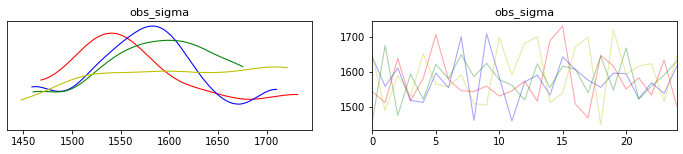

In [369]:
az.plot_trace(params, chain_prop={"color": ['r', 'b', 'g', 'y']}, var_names = "obs_sigma")

Расхождения имеются, но схождения и закономерноси также присутствуют

В алгоритме estimator = 'stan-mcmc' лучшие показатели продемонстрировала модель с global_trend_option = 'loglinear', backtesting = 'expanding'

(Оставил только лучшую модель)

## Среди этих двух моделей лучшие результаты показала модель с алгоритмом 'stan-mcmc'